In [2]:
from student_changepoint import StudentChangepoint
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

In [11]:
cp_bins = StudentChangepoint(data_fname='./test_data.csv', binary=True, result_dir='result_bins')
cp_bins.naive_changepoint_detection(plot=False, debug=False) # Disable 'plot' (plot=False) for faster run
inc_bins, dec_bins, noch_bins = cp_bins.get_inc_dec_noch_sidxs()

cp_cnts = StudentChangepoint(data_fname='./test_data.csv', binary=False, result_dir='result_cnts')
cp_cnts.naive_changepoint_detection(plot=False, debug=False) # Disable 'plot' (plot=False) for faster run
inc_idxs, dec_idxs, noch_idxs = cp_cnts.get_inc_dec_noch_sidxs()


Loading the data from ./test_data.csv
Running Bernoulli changepoint detection.
  ---> took 30 seconds.

Loading the data from ./test_data.csv
Running Poisson changepoint detection.
  ---> took 71 seconds.


In [14]:
def plot_one_small_mat(axis, data, n_inc, n_dec, cmap, title=''):
    """
    axis: pyplot axis to plot on
    data: numpy 2-dim array
    type_idx: int for title
        0: preview counts
        1: review counts
    n_inc: int
        number of increased students
    n_dec: int
        number of decreased students
    cmap: str or colormap
        colormap to use
    """
    axis.matshow(data, interpolation='nearest', aspect='auto',
                 cmap=cmap)
    axis.xaxis.set_label_position('bottom')
    axis.xaxis.set_ticks_position('bottom')
    axis.tick_params(labelsize=13)
    axis.set_xlabel('DAYS', fontsize=14)
    axis.set_yticks([])
    axis.set_title(title, fontsize=15)
    
    tot_n_rows = float(n_inc + n_dec)
    dec_start = 0
    dec_end = n_dec / tot_n_rows
    inc_start = dec_end
    inc_end = 1
    inc_mid = (inc_start + inc_end )/ 2.0
    dec_mid = (dec_start + dec_end) / 2.0
    
    # Inc
    axis.annotate('', xy=(1.03, inc_start), xycoords='axes fraction',
                  xytext=(1.03, inc_end),
                  arrowprops=dict(arrowstyle="<->", color='#114B5F', linewidth=3))
    axis.annotate('$N_{I nc}$', xy=(1.045, inc_mid), xycoords='axes fraction',
                  xytext=(1.045, inc_mid), va='center', ha='left', fontsize=16)
    # Dec
    axis.annotate('', xy=(1.03, dec_start), xycoords='axes fraction',
                  xytext=(1.03, dec_end), 
                  arrowprops=dict(arrowstyle="<->", color='#840032', linewidth=3))
    axis.annotate('$N_{D ec}$', xy=(1.045, dec_mid), xycoords='axes fraction',
                  xytext=(1.045, dec_mid), va='center', ha='left', fontsize=16)

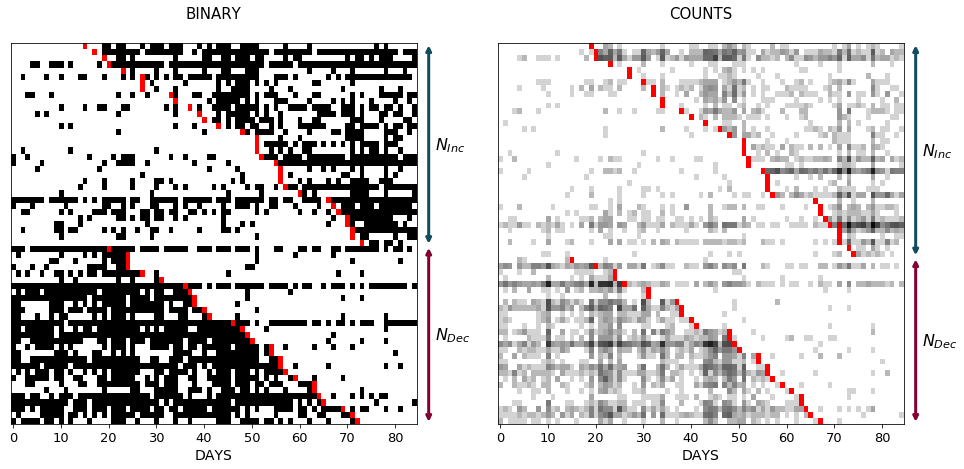

In [15]:
canvascps = [cp_bins, cp_cnts]
title_list = ['BINARY', 'COUNTS']

fig, axs = plt.subplots(1,2, figsize=(16,7))

for idx, ax in enumerate(axs):
    canvascp = canvascps[idx]
    groups_of_sidxs_ranked = canvascp.rank_students_by_cp()

    list_of_data  = []  # will create a matrix to plot
    n_inc = len(groups_of_sidxs_ranked[0])
    n_dec = len(groups_of_sidxs_ranked[1])

    max_entry_val = np.round(np.max(canvascp.glm_mat[:,1]))
    
    # Just plot two groups (inc/dec)
    for i, sidxs_ranked in enumerate(groups_of_sidxs_ranked[:2]):
        for sidx in sidxs_ranked:
            data = np.array(canvascp.get_one_student_data(canvascp.glm_mat, sidx))
            cp = int(canvascp.detected_cp_arr[sidx])
            # Code the change-point as (max_value + 1) -> it will show as red by the colormap
            data[cp] = max_entry_val + 1
            # Append the modified value
            list_of_data.append(data[:, 1])

    # Set the color map as [white, gray1, gray2, ..., grayN, red]
    # so that the changepoint (which has the max val) can be shown as RED
    if max_entry_val == 1:
        color_list = [(1,1,1),(0,0,0),(1,0,0)]
    else:
        increment = 1.0 / (max_entry_val-1)
        color_list = []
        for i in range(int(max_entry_val)):
            val = 1-increment*i
            color_list.append((val, val, val))
        color_list.append((1,0,0))

    cm = LinearSegmentedColormap.from_list("WBR", color_list)
    data_mat = np.array(list_of_data)

    if canvascp.binary:
        plot_one_small_mat(ax, data_mat, n_inc=n_inc, n_dec=n_dec, cmap=cm, title=title_list[idx])
    else:
        plot_one_small_mat(ax, np.log(data_mat+1), n_inc=n_inc, n_dec=n_dec, cmap=cm, title=title_list[idx])

# fname = 'two_mats.pdf'
# plt.savefig(fname)